## Simple Baseline

Stripped down architecture consisting of a single GMEdgeConv and clustering. Dataset will consist of 5 examples. 

1. Build a one‑layer GMEdgeConv to be a feature extractor.
2. Head: small MLP to predict per‑vertex displacements.
3. Cluster displaced vertices via mean‑shift to joint coordinates. "Naive attention" (all values are 1)=
4. Loss: Chamfer distance between predicted and ground‑truth joints.

In [1]:
import open3d as o3d
import numpy as np

In [ ]:
def points_to_spheres(points, color=[0, 1, 1]):
    spheres = []
    for (x, y, z) in np.asarray(points):
        sphere = o3d.geometry.TriangleMesh.create_sphere(radius=0.01)
        sphere.translate((x, y, z))
        sphere.paint_uniform_color(color)
        spheres.append(sphere)
    
    return spheres

def visualize_mesh_graph(vertices: np.ndarray,
                        edge_list: np.ndarray,
                        joints_gt: np.ndarray = None, 
                        joints_pred: np.ndarray = None,
                        mesh: o3d.geometry.TriangleMesh = None):

    pts = vertices.astype(dtype=np.float64)
    lines = edge_list.astype(dtype=np.int32)
    
    line_set = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(pts),
        lines=o3d.utility.Vector2iVector(lines)
    )

    colors = [[1.0, 0.0, 0.0] for _ in lines]
    line_set.colors = o3d.utility.Vector3dVector(colors)
    
    to_draw = []
    to_draw.append(line_set)

    if joints_gt is not None:
        to_draw.extend(points_to_spheres(joints_gt, color=[0, 1, 1]))
    
    if joints_pred is not None:
        to_draw.extend(points_to_spheres(joints_pred, color=[1, 0, 1]))

    if mesh is not None:
        mesh.compute_vertex_normals()
        mesh.paint_uniform_color([0.8, 0.8, 0.8])
        to_draw.append(mesh)
    
    o3d.visualization.draw_geometries(to_draw,
                                      mesh_show_back_face=True,
                                      window_name="Mesh Graph",
                                      width=800, height=600)

### Simple Baseline

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch_scatter import scatter_max

import matplotlib.pyplot as plt

import random
import pickle
from tqdm import tqdm

from my_rignet_utils import mean_shift_clustering, mode_extraction

In [4]:
class RigNetDataset(Dataset):
    def __init__(self, file_path, transform=None, seed=42):

        with open(file_path, 'rb') as f:
            data = pickle.load(f)

        random.Random(seed).shuffle(data)
        self.examples = data[:5]

        self.transform = transform

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, index):
        sample = self.examples[index]
        if self.transform is not None:
            sample = self.transform(sample)
        return sample


In [5]:
# Use Val set for training for faster loading, then we'll use test set for testing
TRAIN_FILE_PATH = "data/ModelResource_RigNetv1_preproccessed/mesh_graphs/val.pkl"
VAL_FILE_PATH = "data/ModelResource_RigNetv1_preproccessed/mesh_graphs/test.pkl"
train_dataset = RigNetDataset(TRAIN_FILE_PATH, seed=0)
val_dataset = RigNetDataset(VAL_FILE_PATH, seed=1)
train_dataset[0].keys()

dict_keys(['obj_path', 'vertices', 'one_ring', 'centroid', 'geodesic', 'joints'])

### Network Architecture

#### GMEdgeConv
- Input: vertices of in_dim, one-ring edge list and geodesic edge list

Process: MLP(max(MLP(one-ring)) | max(MLP(geodesic)))

- output: vertices of out_dim

In [6]:
class GMEdgeConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        in_channels:  F_in, dimension of input vertex features
        out_channels: F_out, dimension of output vertex features
        """
        super().__init__()
        hidden = out_channels 
        # Edge MLPs for topo and geo neighborhoods
        self.mlp_topo = nn.Sequential(
            nn.Linear(2*in_channels, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU()
        )
        self.mlp_geo = nn.Sequential(
            nn.Linear(2*in_channels, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU()
        )
        # Fuse MLP to combine topo+geo pooled features
        self.mlp_fuse = nn.Sequential(
            nn.Linear(2*hidden, out_channels),
            nn.ReLU()
        )

    def forward(self, x, edge_index_topo, edge_index_geo):

        N, F_in = x.shape

        # --- one-ring ---

        # [E_topo] (num one-ring/topological edges)
        i_t, j_t = edge_index_topo  

        # Index all xi-xj vertex pairs
        xi = x[i_t] # [E_topo, F_in]
        xj = x[j_t] # [E_topo, F_in]
        edge_feat_t = torch.cat([xi, xj - xi], dim=1) # [E_topo, 2*F_in]
        # Apply topological convolutional mlp
        edge_feat_t = self.mlp_topo(edge_feat_t) # [E_topo, hidden]

        # Pool max over neighbors per i_t
        # During mesh graph creation, it was guaranteed that each vertex has at least one neighbor (itself)
        topo_pooled, _ = scatter_max(edge_feat_t, i_t, dim=0, dim_size=N)

        # --- geodesic edges ---
        i_g, j_g = edge_index_geo
        xi_g = x[i_g]
        xj_g = x[j_g]
        edge_feat_g = torch.cat([xi_g, xj_g - xi_g], dim=1)  # [E_geo, 2*F_in]
        edge_feat_g = self.mlp_geo(edge_feat_g) # [E_geo, hidden]

        geo_pooled, _ = scatter_max(edge_feat_g, i_g, dim=0, dim_size=N)
        # geo_pooled: [N, hidden]

        # --- fuse ---
        combined = torch.cat([topo_pooled, geo_pooled], dim=1)  # [N, 2*hidden]
        x_out = self.mlp_fuse(combined) # [N, out_channels]

        return x_out


In [7]:
class SimpleJointNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = GMEdgeConv(in_channels=3, out_channels=64)
        self.disp_head = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 3)
        )
    def forward(self, x, edges_topo, edges_geo):
        # x: [N,3]
        N, D = x.shape
        feat = self.conv(x, edges_topo, edges_geo) # [N,64]
        disp = self.disp_head(feat) # [N,3]
        q = x + disp # displaced points [N,3]

        # cluster
        attention = torch.ones(N)
        # h=0.057 learned in paper
        T_pred = mean_shift_clustering(q, attention, h=0.057)
        T_pred = mode_extraction(T_pred, attention, h=0.057)
        return T_pred

In [8]:
def chamfer_loss(T_pred, T_gt):
    # T_pred: [K,3], T_gt: [M,3]
    # compute pairwise distances [K, M]
    # Distance between two arbitrary point clouds
    d2 = torch.cdist(T_pred, T_gt, p=2)  
    loss = d2.min(dim=1)[0].mean() + d2.min(dim=0)[0].mean()
    return loss

### Train

In [43]:
model = SimpleJointNet()

In [44]:
G = train_dataset[0]
verts = torch.FloatTensor(G['vertices'])
one_ring = torch.LongTensor(G['one_ring'])
geodesic = torch.LongTensor(G['geodesic'])
joints_gt = torch.FloatTensor(G["joints"])

verts.shape, one_ring.shape

(torch.Size([761, 3]), torch.Size([4977, 2]))

100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


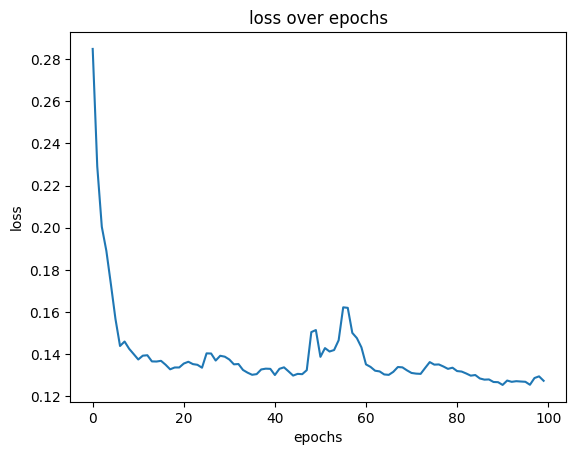

In [45]:
epochs = 100
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

losses = []
for _ in tqdm(range(epochs)):

    loss_sum = 0
    iters = 0
    for i in range(len(train_dataset)):
        G = train_dataset[i]

        verts = torch.FloatTensor(G['vertices'])
        one_ring = torch.LongTensor(G['one_ring']).view(2, -1)
        geodesic = torch.LongTensor(G['geodesic']).view(2, -1)
        joints_gt = torch.FloatTensor(G["joints"])

        joints_pred = model.forward(verts, one_ring, geodesic)
        loss = chamfer_loss(joints_pred, joints_gt)
        loss_sum += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        iters += 1
    
    avg_loss = loss_sum / iters
    losses.append(avg_loss)

plt.figure()
plt.title("loss over epochs")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot(losses)

### Testing

In [50]:
def validate_model(model: SimpleJointNet):
    loss_sum = 0
    iters = 0
    for i in range(len(val_dataset)):
        G = val_dataset[i]

        verts = torch.FloatTensor(G['vertices'])
        one_ring = torch.LongTensor(G['one_ring']).view(2, -1)
        geodesic = torch.LongTensor(G['geodesic']).view(2, -1)
        joints_gt = torch.FloatTensor(G["joints"])

        joints_pred = model.forward(verts, one_ring, geodesic)
        loss = chamfer_loss(joints_pred, joints_gt)
        loss_sum += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        iters += 1

    print("val loss")
    print(loss_sum / iters)

In [52]:
untrained_model = SimpleJointNet()
print('trained model')
validate_model(model)
print('---\nuntrained model')
validate_model(untrained_model)

trained model
val loss
0.17849247455596923
---
untrained model
val loss
0.33026050329208373


In [53]:
G = train_dataset[0]
verts = torch.FloatTensor(G['vertices'])
one_ring = torch.LongTensor(G['one_ring'])
geodesic = torch.LongTensor(G['geodesic'])
joints_gt = torch.FloatTensor(G["joints"])

In [54]:
joints_pred = model(verts, one_ring.view(2, -1), geodesic.view(2, -1))

print(len(joints_pred), len(joints_gt))

visualize_mesh_graph(verts.detach().numpy(), 
                     one_ring.detach().numpy(), 
                     joints_gt.detach().numpy(), 
                     joints_pred.detach().numpy())


38 16


### Val dataset 

In [55]:
G = val_dataset[0]
verts = torch.FloatTensor(G['vertices'])
one_ring = torch.LongTensor(G['one_ring'])
geodesic = torch.LongTensor(G['geodesic'])
joints_gt = torch.FloatTensor(G["joints"])

In [56]:
joints_pred = model(verts, one_ring.view(2, -1), geodesic.view(2, -1))

visualize_mesh_graph(verts.detach().numpy(), 
                     one_ring.detach().numpy(), 
                     joints_gt.detach().numpy(), 
                     joints_pred.detach().numpy())

In [57]:
joints_pred = untrained_model(verts, one_ring.view(2, -1), geodesic.view(2, -1))

visualize_mesh_graph(verts.detach().numpy(), 
                     one_ring.detach().numpy(), 
                     joints_gt.detach().numpy(), 
                     joints_pred.detach().numpy())